In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16
import opendatasets as od
import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [17]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [18]:
MAIN_DIR = r"E:\GAN Output\kaggle output\brain-mri-images-for-brain-tumor-detection\yes"

# Loading and Preprocessing the Images

In [19]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [20]:
od.download("https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection")

Skipping, found downloaded files in ".\brain-mri-images-for-brain-tumor-detection" (use force=True to force download)


In [21]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((155, 128, 128), (155,))

## Generate 20 random numbers to index images from data

In [22]:
np.random.seed(SEED)
idxs = np.random.randint(0, 98, 20)

In [23]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

## Normalize and Reshape the Data

In [24]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

## Plotting The Real Images

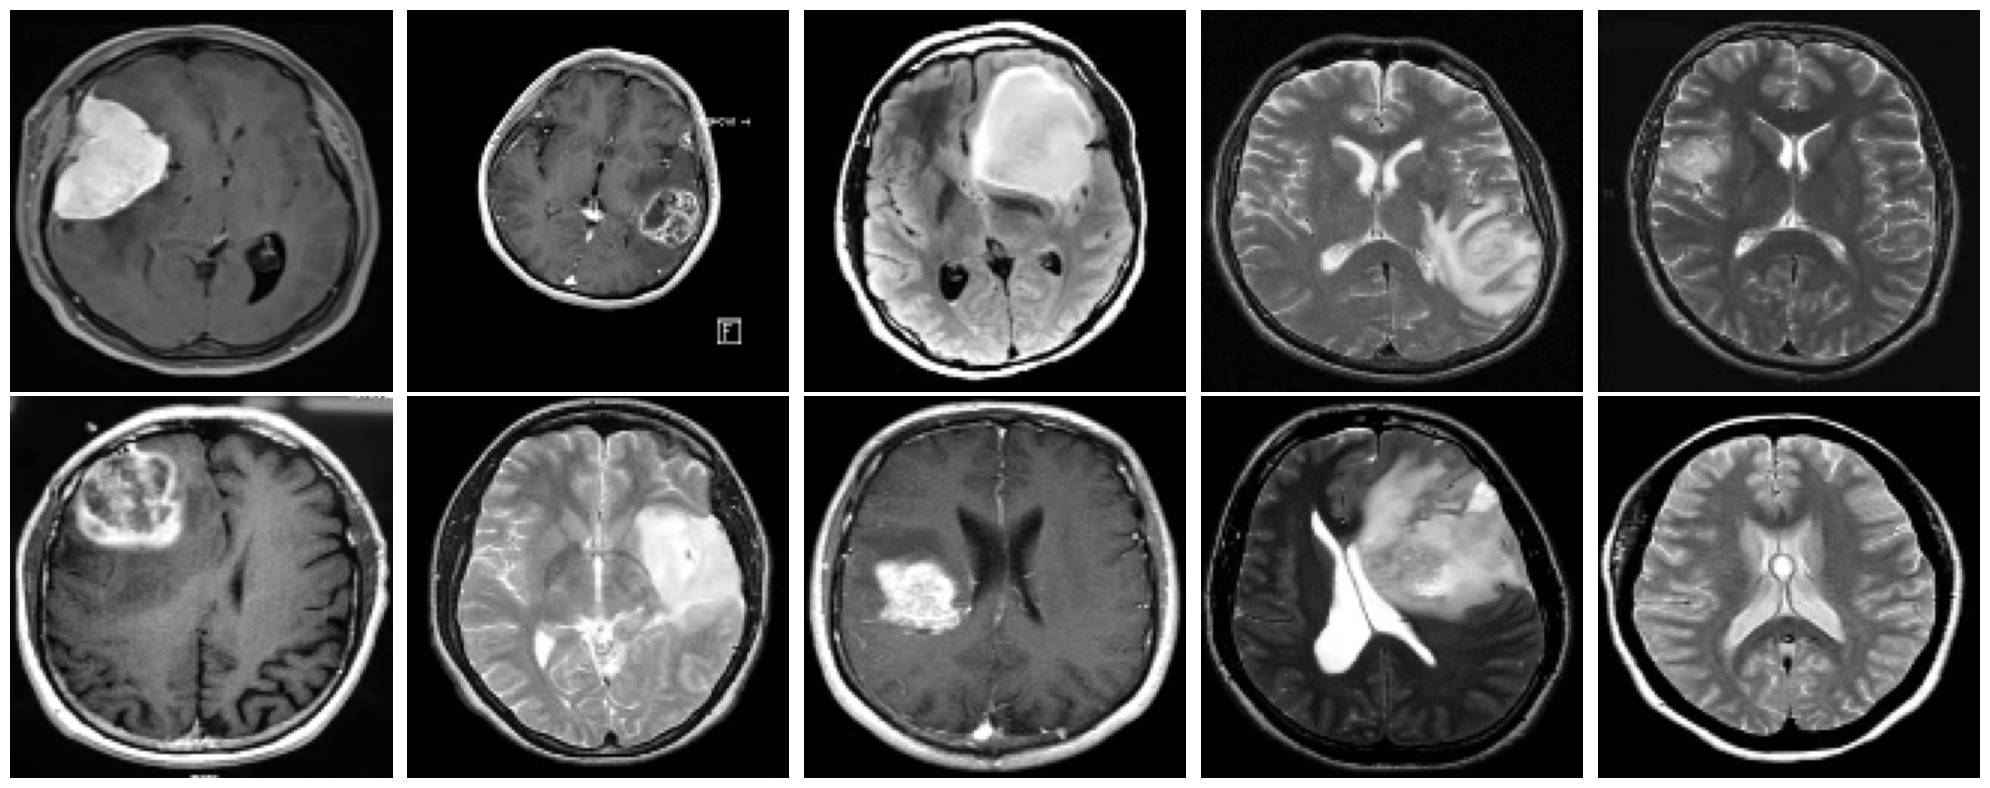

In [25]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# The Architecture

In [26]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [27]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

# Putting it together

In [28]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,785 (2.22 MB)

 Trainable params: 582,785 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 262144)         │    26,476,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,265,281 (104.01 MB)

 Trainable params: 27,265,281 (104.01 MB)

 Non-trainable params: 0 (0.00 B)

The Combined Network:



Model: "gan_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ (None, 128, 128, 1)    │    27,265,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ (None, 1)              │       582,785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,848,066 (106.23 MB)

 Trainable params: 27,265,281 (104.01 MB)

 Non-trainable params: 582,785 (2.22 MB)

In [29]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## The Training

 99%|█████████▉| 3711/3750 [50:53<00:29,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 99%|█████████▉| 3712/3750 [50:54<00:28,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 99%|█████████▉| 3713/3750 [50:55<00:28,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 99%|█████████▉| 3714/3750 [50:55<00:27,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 99%|█████████▉| 3715/3750 [50:56<00:26,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 99%|█████████▉| 3716/3750 [50:57<00:25,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 99%|█████████▉| 3717/3750 [50:58<00:24,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 99%|█████████▉| 3718/3750 [50:58<00:24,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 99%|█████████▉| 3719/3750 [50:59<00:23,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 99%|█████████▉| 3720/3750 [51:00<00:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 99%|█████████▉| 3721/3750 [51:01<00:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 99%|█████████▉| 3722/3750 [51:01<00:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 99%|█████████▉| 3723/3750 [51:02<00:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 99%|█████████▉| 3724/3750 [51:03<00:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 99%|█████████▉| 3725/3750 [51:04<00:18,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 99%|█████████▉| 3726/3750 [51:04<00:17,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 99%|█████████▉| 3727/3750 [51:05<00:17,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 99%|█████████▉| 3728/3750 [51:06<00:16,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 99%|█████████▉| 3729/3750 [51:07<00:15,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 99%|█████████▉| 3730/3750 [51:07<00:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 99%|█████████▉| 3731/3750 [51:08<00:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████▉| 3732/3750 [51:09<00:13,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████▉| 3733/3750 [51:10<00:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


100%|█████████▉| 3734/3750 [51:10<00:12,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


100%|█████████▉| 3735/3750 [51:11<00:11,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


100%|█████████▉| 3736/3750 [51:12<00:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


100%|█████████▉| 3737/3750 [51:13<00:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


100%|█████████▉| 3738/3750 [51:13<00:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


100%|█████████▉| 3739/3750 [51:14<00:08,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


100%|█████████▉| 3740/3750 [51:15<00:07,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


100%|█████████▉| 3741/3750 [51:16<00:06,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


100%|█████████▉| 3742/3750 [51:16<00:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|█████████▉| 3743/3750 [51:17<00:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


100%|█████████▉| 3744/3750 [51:18<00:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


100%|█████████▉| 3745/3750 [51:19<00:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


100%|█████████▉| 3746/3750 [51:19<00:03,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


100%|█████████▉| 3747/3750 [51:20<00:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


100%|█████████▉| 3748/3750 [51:21<00:01,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|█████████▉| 3749/3750 [51:22<00:00,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


100%|██████████| 3750/3750 [51:22<00:00,  1.22it/s]

EPOCH: 5 Generator Loss: 0.0392 Discriminator Loss: 2.0177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


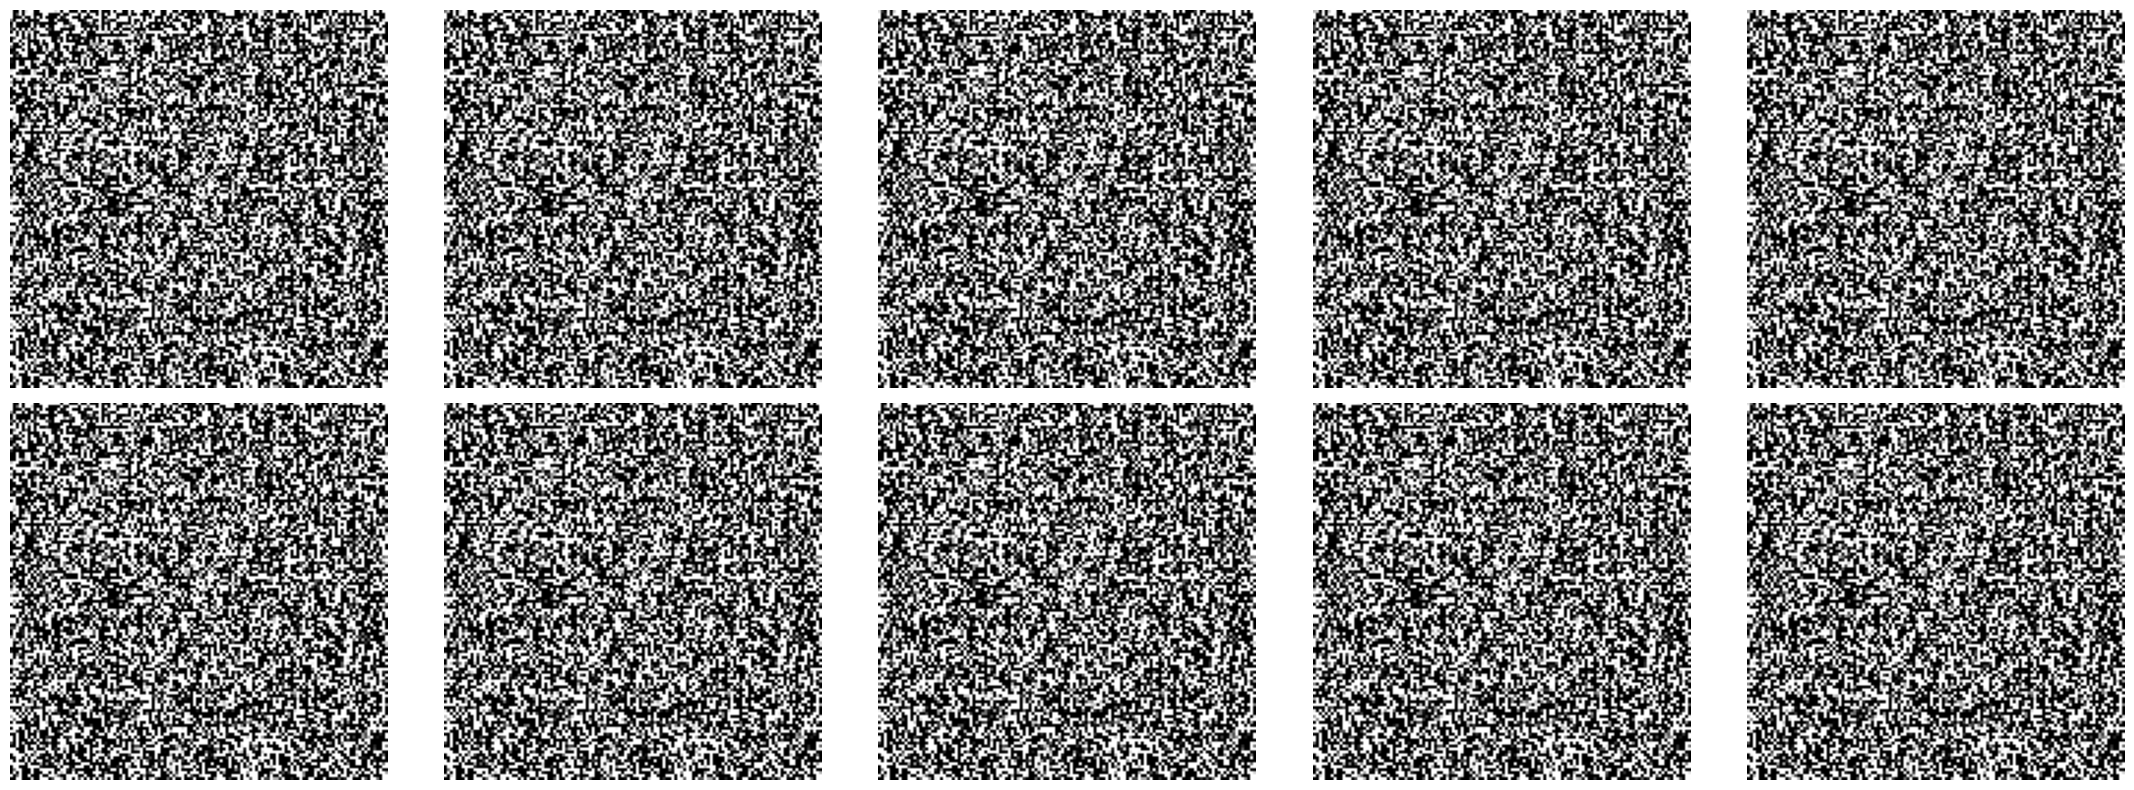

  0%|          | 0/3750 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  0%|          | 1/3750 [00:00<49:34,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  0%|          | 2/3750 [00:01<50:46,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  0%|          | 3/3750 [00:02<50:03,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  0%|          | 4/3750 [00:03<49:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  0%|          | 5/3750 [00:04<50:30,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  0%|          | 6/3750 [00:04<50:43,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  0%|          | 7/3750 [00:05<49:56,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  0%|          | 8/3750 [00:06<49:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  0%|          | 9/3750 [00:07<49:06,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  0%|          | 10/3750 [00:07<49:44,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  0%|          | 11/3750 [00:08<53:33,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  0%|          | 12/3750 [00:09<52:22,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  0%|          | 13/3750 [00:10<50:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  0%|          | 14/3750 [00:11<50:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


  0%|          | 15/3750 [00:12<49:58,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  0%|          | 16/3750 [00:12<49:27,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  0%|          | 17/3750 [00:13<48:56,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  0%|          | 18/3750 [00:14<48:04,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  1%|          | 19/3750 [00:15<47:52,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  1%|          | 20/3750 [00:15<47:55,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


  1%|          | 21/3750 [00:16<48:43,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  1%|          | 22/3750 [00:17<49:15,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  1%|          | 23/3750 [00:18<50:12,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  1%|          | 24/3750 [00:19<49:57,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  1%|          | 25/3750 [00:20<49:48,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  1%|          | 26/3750 [00:20<49:08,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  1%|          | 27/3750 [00:21<48:51,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  1%|          | 28/3750 [00:22<48:01,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  1%|          | 29/3750 [00:23<49:21,  1.26it/s]


KeyboardInterrupt: 

In [30]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

# Let's generate some images !

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

# Testing the Generated sample: Plotting the Distributions

<p style="font-size:20px">In this test, we compare the generated images with the real samples by plotting their distributions. If the distributions overlap, that indicates the generated samples are very close to the real ones
</p>

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

(100, 128, 128, 1)

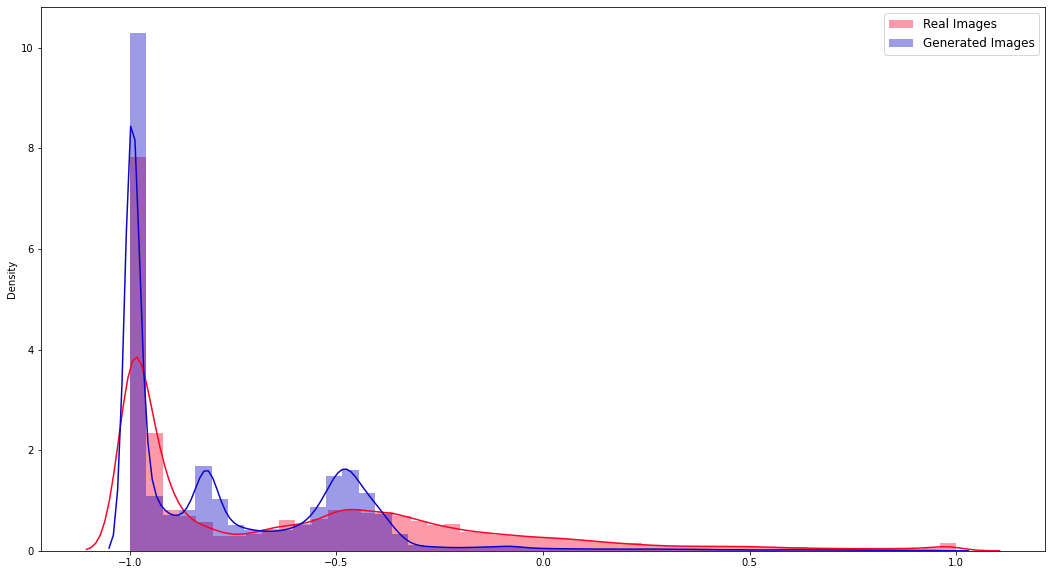

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

In [ ]:
generator.save('final_generator.keras')
discriminator.save('final_discriminator.keras')